In [1]:
import os
import re
import math
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

import requests
from tqdm.auto import tqdm

import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Resampling as ResamplingEnum

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
# Configuration
LINKS_URL = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/OPR/Projects/CO_DRCOG_2020_B20/CO_DRCOG_2_2020/0_file_download_links.txt"

OUT_DIR = Path("/Users/thowe/Downloads/usgs_lidar")
TILES_DIR = OUT_DIR / "tiles"
MOSAIC_PATH = OUT_DIR / "mosaic_dem.tif"

OUT_DIR.mkdir(parents=True, exist_ok=True)
TILES_DIR.mkdir(parents=True, exist_ok=True)

REQUESTS_TIMEOUT = 60
MAX_WORKERS = 8

# If you want a consistent output CRS, set TARGET_CRS (e.g., "EPSG:3857").
# If None, the mosaic will be written in the CRS of the first tile.
TARGET_CRS = None

# Preview settings (no downloads): how many tiles to sample for remote metadata preview
PREVIEW_SAMPLE_N = 30

In [3]:
# Fetch and parse the list of download links
resp = requests.get(LINKS_URL, timeout=REQUESTS_TIMEOUT)
resp.raise_for_status()

raw_lines = [ln.strip() for ln in resp.text.splitlines() if ln.strip()]
urls = [ln for ln in raw_lines if re.match(r"^https?://", ln)]

print(f"Total links found: {len(urls)}")
print("First 10 links:")
for u in urls[:10]:
    print(u)


Total links found: 3451
First 10 links:
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/OPR/Projects/CO_DRCOG_2020_B20/CO_DRCOG_2_2020/TIFF/USGS_OPR_CO_DRCOG_2020_B20_w0475n4365.tif
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/OPR/Projects/CO_DRCOG_2020_B20/CO_DRCOG_2_2020/TIFF/USGS_OPR_CO_DRCOG_2020_B20_w0516n4405.tif
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/OPR/Projects/CO_DRCOG_2020_B20/CO_DRCOG_2_2020/TIFF/USGS_OPR_CO_DRCOG_2020_B20_w0513n4381.tif
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/OPR/Projects/CO_DRCOG_2020_B20/CO_DRCOG_2_2020/TIFF/USGS_OPR_CO_DRCOG_2020_B20_w0507n4363.tif
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/OPR/Projects/CO_DRCOG_2020_B20/CO_DRCOG_2_2020/TIFF/USGS_OPR_CO_DRCOG_2020_B20_w0489n4423.tif
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/OPR/Projects/CO_DRCOG_2020_B20/CO_DRCOG_2_2020/TIFF/USGS_OPR_CO_DRCOG_2020_B20_w0516n4369.tif
https://prd-tnm.s3.amazonaws.com/StagedProducts/

Reading remote metadata (sample):   0%|          | 0/30 [00:00<?, ?it/s]

Metadata read OK: 30 / 30
CRS (sample): {'COMPD_CS["NAD83(2011) / UTM zone 13N + NAVD88 height",PROJCS["NAD83(2011) / UTM zone 13N",GEOGCS["NAD83(2011)",DATUM["NAD83_National_Spatial_Reference_System_2011",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6318"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6342"]],VERT_CS["NAVD88 height",VERT_DATUM["North American Vertical Datum 1988",2005,AUTHORITY["EPSG","5103"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Gravity-related height",UP],AUTHORITY["EPSG","5703"]]]'}
Resolution (sample): [(1.0, 1.0)] 
Dtypes (sample)

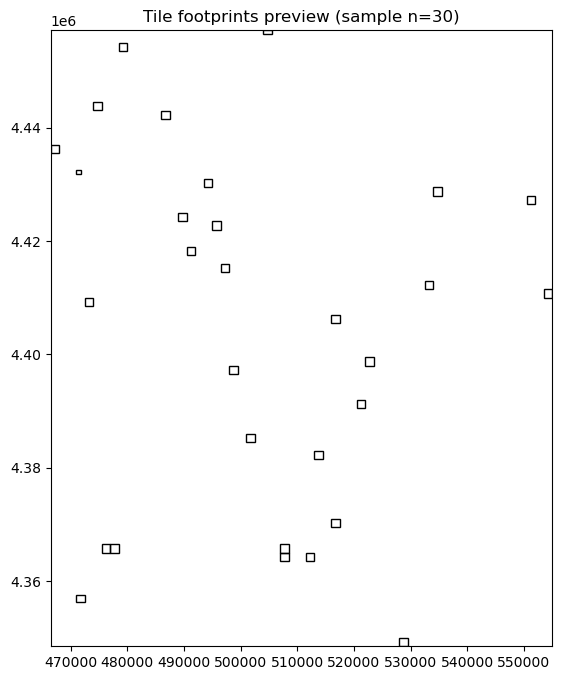

Sample bounds:
  left: 466500.0
  bottom: 4348500.0
  right: 555000.0
  top: 4457215.0


In [4]:
# Preview cell (no downloads): sample remote rasters for footprint + basic stats
# This uses GDAL's /vsicurl/ via rasterio to read metadata without downloading entire files.

def open_remote_meta(url: str):
    vsicurl_path = f"/vsicurl/{url}"
    with rasterio.open(vsicurl_path) as src:
        return {
            "url": url,
            "crs": src.crs,
            "bounds": src.bounds,   # left, bottom, right, top
            "res": src.res,         # (xres, yres)
            "dtype": src.dtypes[0],
            "nodata": src.nodata,
            "width": src.width,
            "height": src.height,
        }

sample_urls = urls[: min(PREVIEW_SAMPLE_N, len(urls))]

metas = []
errors = []
for u in tqdm(sample_urls, desc="Reading remote metadata (sample)"):
    try:
        metas.append(open_remote_meta(u))
    except Exception as e:
        errors.append((u, repr(e)))

print(f"Metadata read OK: {len(metas)} / {len(sample_urls)}")
if errors:
    print("Errors (first 5):")
    for u, e in errors[:5]:
        print(u, e)

if metas:
    crs_set = {m["crs"].to_string() if m["crs"] else None for m in metas}
    res_set = {m["res"] for m in metas}
    dtype_set = {m["dtype"] for m in metas}

    print("CRS (sample):", crs_set)
    print("Resolution (sample):", sorted(list(res_set))[:10], "..." if len(res_set) > 10 else "")
    print("Dtypes (sample):", dtype_set)

    # Plot footprints in the sample
    lefts = [m["bounds"].left for m in metas]
    rights = [m["bounds"].right for m in metas]
    bottoms = [m["bounds"].bottom for m in metas]
    tops = [m["bounds"].top for m in metas]

    fig, ax = plt.subplots(figsize=(8, 8))
    for m in metas:
        b = m["bounds"]
        ax.add_patch(Rectangle((b.left, b.bottom), b.right - b.left, b.top - b.bottom, fill=False, linewidth=1))
    ax.set_title(f"Tile footprints preview (sample n={len(metas)})")
    ax.set_xlim(min(lefts), max(rights))
    ax.set_ylim(min(bottoms), max(tops))
    ax.set_aspect("equal", adjustable="box")
    plt.show()

    # Show estimated sample mosaic bounds
    print("Sample bounds:")
    print("  left:", min(lefts))
    print("  bottom:", min(bottoms))
    print("  right:", max(rights))
    print("  top:", max(tops))

In [5]:
# Download all tiles (streaming) to TILES_DIR

def local_path_for_url(url: str) -> Path:
    name = url.split("/")[-1]
    return TILES_DIR / name

def download_one(url: str, dest: Path, overwrite: bool = False) -> Path:
    if dest.exists() and not overwrite and dest.stat().st_size > 0:
        return dest

    with requests.get(url, stream=True, timeout=REQUESTS_TIMEOUT) as r:
        r.raise_for_status()
        tmp = dest.with_suffix(dest.suffix + ".part")
        with open(tmp, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
        os.replace(tmp, dest)
    return dest

tile_paths = [local_path_for_url(u) for u in urls]

futures = []
downloaded = []
failed = []

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    for u in urls:
        futures.append(ex.submit(download_one, u, local_path_for_url(u)))

    for fut in tqdm(as_completed(futures), total=len(futures), desc="Downloading tiles"):
        try:
            downloaded.append(fut.result())
        except Exception as e:
            failed.append(repr(e))

print(f"Downloaded/available tiles: {len(downloaded)} / {len(urls)}")
if failed:
    print(f"Failed downloads: {len(failed)} (showing first 5)")
    for e in failed[:5]:
        print(e)

Downloaded/available tiles: 3451 / 3451


In [6]:
# Stitch into a single DEM (GeoTIFF mosaic)

def reproject_to_target(src_path: Path, target_crs: str, out_dir: Path) -> Path:
    out_path = out_dir / (src_path.stem + f"_reproj_{target_crs.replace(':','_')}.tif")
    if out_path.exists() and out_path.stat().st_size > 0:
        return out_path

    with rasterio.open(src_path) as src:
        dst_transform, dst_width, dst_height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )
        dst_profile = src.profile.copy()
        dst_profile.update(
            crs=target_crs,
            transform=dst_transform,
            width=dst_width,
            height=dst_height,
            tiled=True,
            compress="deflate",
            predictor=2,
            bigtiff="if_safer",
        )

        nodata = src.nodata
        with rasterio.open(out_path, "w", **dst_profile) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=target_crs,
                    resampling=Resampling.bilinear,
                    src_nodata=nodata,
                    dst_nodata=nodata,
                )
    return out_path

# Open sources (optionally reproject to a target CRS first)
sources = []
tmp_reproj_dir = OUT_DIR / "reprojected"
tmp_reproj_dir.mkdir(parents=True, exist_ok=True)

paths_for_merge = tile_paths

if TARGET_CRS is not None:
    reproj_paths = []
    for p in tqdm(paths_for_merge, desc="Reprojecting to target CRS"):
        reproj_paths.append(reproject_to_target(p, TARGET_CRS, tmp_reproj_dir))
    paths_for_merge = reproj_paths

for p in tqdm(paths_for_merge, desc="Opening tiles for merge"):
    sources.append(rasterio.open(p))

try:
    mosaic, out_transform = merge(sources, nodata=sources[0].nodata)
    out_profile = sources[0].profile.copy()
    out_profile.update(
        height=mosaic.shape[1],
        width=mosaic.shape[2],
        transform=out_transform,
        count=mosaic.shape[0],
        tiled=True,
        compress="deflate",
        predictor=2,
        bigtiff="if_safer",
    )

    MOSAIC_PATH.parent.mkdir(parents=True, exist_ok=True)
    with rasterio.open(MOSAIC_PATH, "w", **out_profile) as dst:
        dst.write(mosaic)

finally:
    for s in sources:
        s.close()

print(f"Wrote mosaic: {MOSAIC_PATH}")

Opening tiles for merge:   0%|          | 0/3451 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Quick preview of the final mosaic (downsampled for display)
with rasterio.open(MOSAIC_PATH) as src:
    band = src.read(1, out_shape=(1, max(1, src.height // 10), max(1, src.width // 10)), resampling=ResamplingEnum.average)
    nodata = src.nodata

arr = band.astype("float32")
if nodata is not None:
    arr[arr == nodata] = np.nan

plt.figure(figsize=(10, 8))
plt.imshow(arr, interpolation="nearest")
plt.title("Mosaic DEM preview (downsampled)")
plt.colorbar()
plt.show()

In [ ]:
# Diagnostic: estimate mosaic pixel dimensions + RAM need (without merging)
# Assumes you still have: tile_paths (list[Path]) and MOSAIC_PATH, OUT_DIR set.

def fmt_bytes(n: float) -> str:
    units = ["B", "KB", "MB", "GB", "TB", "PB"]
    i = 0
    while n >= 1024 and i < len(units) - 1:
        n /= 1024
        i += 1
    return f"{n:.2f} {units[i]}"

print("Tiles:", len(tile_paths))

# Check one tile for CRS/res/count/dtype
with rasterio.open(tile_paths[0]) as src0:
    crs0 = src0.crs
    res0 = src0.res
    dtype0 = src0.dtypes[0]
    count0 = src0.count
    nodata0 = src0.nodata
    print("Example tile:")
    print("  path:", tile_paths[0])
    print("  crs:", crs0)
    print("  res:", res0)
    print("  dtype:", dtype0)
    print("  count:", count0)
    print("  nodata:", nodata0)

# Union bounds across all tiles (opens each tile to read bounds only)
left = float("inf")
bottom = float("inf")
right = float("-inf")
top = float("-inf")
mismatch = {"crs": 0, "res": 0, "dtype": 0, "count": 0}

for p in tqdm(tile_paths, desc="Scanning bounds"):
    with rasterio.open(p) as s:
        b = s.bounds
        left = min(left, b.left)
        bottom = min(bottom, b.bottom)
        right = max(right, b.right)
        top = max(top, b.top)

        if s.crs != crs0:
            mismatch["crs"] += 1
        if s.res != res0:
            mismatch["res"] += 1
        if s.dtypes[0] != dtype0:
            mismatch["dtype"] += 1
        if s.count != count0:
            mismatch["count"] += 1

width_px = math.ceil((right - left) / res0[0])
height_px = math.ceil((top - bottom) / abs(res0[1]))

bytes_per_px = rasterio.dtypes.get_minimum_dtype(np.zeros(1, dtype=dtype0)).itemsize if hasattr(__import__("numpy"), "zeros") else rasterio.dtypes.dtype_ranges[dtype0]
# Safer: map dtype to itemsize without needing numpy
dtype_itemsize = rasterio.dtypes._gdal_typename_to_numpy_dtype.get(dtype0, None)
if dtype_itemsize is None:
    # fallback common cases
    dtype_sizes = {"uint8": 1, "int16": 2, "uint16": 2, "int32": 4, "uint32": 4, "float32": 4, "float64": 8}
    dtype_itemsize = dtype_sizes.get(dtype0, 4)
else:
    dtype_itemsize = dtype_itemsize().itemsize

est_mosaic_bytes = width_px * height_px * count0 * dtype_itemsize

vm = psutil.virtual_memory()
print("\nUnion bounds:")
print("  left:", left)
print("  bottom:", bottom)
print("  right:", right)
print("  top:", top)
print("\nEstimated mosaic size:")
print("  width_px:", width_px)
print("  height_px:", height_px)
print("  bands:", count0)
print("  dtype:", dtype0, f"({dtype_itemsize} bytes/px)")
print("  estimated array bytes (in-RAM for merge output):", fmt_bytes(est_mosaic_bytes))
print("\nMemory:")
print("  total:", fmt_bytes(vm.total))
print("  available:", fmt_bytes(vm.available))
print("\nMismatches vs first tile:")
print(mismatch)